In [1]:
import sys
sys.path.append('src')

In [2]:
import pickle
import cv2
import os
import torch
from tqdm import tqdm
import random
from super_gradients.training import models
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import numpy as np
import onnxruntime

[2024-01-30 06:40:56] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/geoffrey.g.delhomme/sg_logs/console.log


[2024-01-30 06:40:56] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-30 06:40:58] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-30 06:40:58] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-30 06:40:58] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
edge_links=[
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 0)
],
edge_colors=[
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0)
],
keypoint_colors=[
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (128, 0, 0)
]

In [5]:
# ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_Q3_baseline/RUN_20231120_213328_350641"
ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613"
# ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_2048_2023_12_baseline/RUN_20240121_212353_299241"
# ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_4096_jit_baseline/RUN_20240124_170907_170984"
# ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_2048_2023_12_baseline/RUN_20240121_212353_299241"
# ckpt_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_4096_jit_baseline/RUN_20240123_103305_386065"

model_filename = "ckpt_best.pth"
# model_filename = "average_model.pth"

In [6]:
model = models.get('yolo_nas_pose_n', num_classes=4, checkpoint_path=ckpt_dirpath + "/" + model_filename)

[2024-01-30 06:41:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/ckpt_best.pth EMA checkpoint.


In [ ]:
from torchinfo import summary
# summary(model, input_size=(1, 3, 1024, 1024))
summary(model, input_size=(1, 3, 2048, 2048))

In [29]:
import copy
from thop import profile, clever_format
input = torch.randn(1, 3, 1024, 1024)
# input = torch.randn(1, 3, 2048, 2048)
# input = torch.randn(1, 3, 4096, 4096)
macs, params = profile(copy.deepcopy(model.cpu()), inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.


26.133G 7.151M


- 4096: 418.129G 7.151M
- 2048: 104.532G 7.151M
- 1024: 26.133G 7.151M

----

In [7]:
import pickle
with open('/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q4/pickles/dataset_train.p', 'rb') as p:
    data = pickle.load(p)

In [8]:
def plot(l):
    image_path = random.choice([x['image_path'] for x in l])
    print(image_path)
    # display(Image(image_path))
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (1024, 750))
    plt.imshow(im)
    plt.axis('off')

In [ ]:
fts = sorted(list(set([x['flight_test'] for x in data if not x['is_synthetic']])))
display(fts)

In [ ]:
set([x['recording_seq_id'] for x in data if x['flight_test'] == 'FT119'])

In [ ]:
plot([x for x in data if x['flight_test'] == 'FT119' and x['recording_seq_id'] == 5])

In [7]:
image_width, image_height = 1024, 750
# image_width, image_height = 2048, 1500
# image_width, image_height = 4096, 3000

conf=0.35
iou=0.2
# video = cv2.VideoWriter("./tmp/mdc.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# video = cv2.VideoWriter("./tmp/mdc2.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# videos_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/videos"
videos_dirpath = ckpt_dirpath+"/videos"
os.makedirs(videos_dirpath, exist_ok=True)
# video = cv2.VideoWriter(videos_dirpath+"/seq02.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# video = cv2.VideoWriter(videos_dirpath+"/seq01.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
video = cv2.VideoWriter(videos_dirpath+"/seq01.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (image_width, image_height))
# video = cv2.VideoWriter(videos_dirpath+"/seq01.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (2048, 1500))

# source_dirpath = "/home/geoffrey.g.delhomme/data/mdc/Approach01"
# source_dirpath = "/home/geoffrey.g.delhomme/data/mdc/Approach02"
source_dirpath = "/home/geoffrey.g.delhomme/data/videos/seq01"
# source_dirpath = "/home/geoffrey.g.delhomme/data/videos/seq01"

model=model.to('cuda')

for f in tqdm(sorted(list(Path(source_dirpath).glob('*.jpg')))):
    im = cv2.imread(f.as_posix())
    # plt.imshow(im)
    # plt.show()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # print(im.shape)
    h, w, _ = im.shape
    ar_target = image_width/image_height
    ar = w/h
    if ar > ar_target:
        h_resize = image_height
        w_resize = int(w/h*h_resize)
    else:
        w_resize = image_width
        h_resize = int(h/w*w_resize)
    im = cv2.resize(im, (w_resize, h_resize))
    im = im[int(h_resize/2-image_height/2):int(h_resize/2+image_height/2), int(w_resize/2-image_width/2):int(w_resize/2+image_width/2)]
    # print(im.shape)
    # plt.imshow(im)
    # plt.show()
    res = model.predict(im, conf=conf, iou=iou, fuse_model=False)._images_prediction_lst[0].draw()
    res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    video.write(res)

video.release()

  1%|          | 29/2361 [00:05<06:44,  5.76it/s]

100%|█████████▉| 2360/2361 [07:53<00:00,  4.88it/s]

100%|██████████| 2361/2361 [07:54<00:00,  4.98it/s]


In [15]:
import functools
import torchvision
from typing import Iterable
from super_gradients.training.transforms.keypoints import KeypointsLongestMaxSize, KeypointsPadIfNeeded, KeypointsImageStandardize
import time
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.predict.predictions import PoseEstimationPrediction
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

def apply_to_image(img, scale, interpolation):
    height, width = img.shape[:2]

    if scale != 1.0:
        new_height, new_width = tuple(int(dim * scale + 0.5) for dim in (height, width))
        img = cv2.resize(img, (new_width, new_height), interpolation=interpolation)
    return img

def longest_max_size(image, max_height=1024, max_width=1024):
    height, width = image.shape[:2]
    scale = min(max_height / height, max_width / width)
    return apply_to_image(image, scale, cv2.INTER_LINEAR)

def pad_if_needed(image, min_height=1024, min_width=1024, image_pad_value=127, padding_mode="bottom_right"):
    height, width = image.shape[:2]

    if padding_mode == "bottom_right":
        pad_left = 0
        pad_top = 0
        pad_bottom = max(0, min_height - height)
        pad_right = max(0, min_width - width)
    elif padding_mode == "center":
        pad_left = max(0, (min_width - width) // 2)
        pad_top = max(0, (min_height - height) // 2)
        pad_bottom = max(0, min_height - height - pad_top)
        pad_right = max(0, min_width - width - pad_left)
    else:
        raise RuntimeError(f"Unknown padding mode: {padding_mode}")

    image_pad_value = tuple(image_pad_value) if isinstance(image_pad_value, Iterable) else tuple([image_pad_value] * image.shape[-1])
    image = cv2.copyMakeBorder(
        image, top=pad_top, bottom=pad_bottom, left=pad_left, right=pad_right, value=image_pad_value, borderType=cv2.BORDER_CONSTANT
    )

    return image

def preprocess(image):
    image = longest_max_size(
        image,
        max_height=1024,
        max_width=1024
    )
    image = pad_if_needed(
        image,
        min_height=1024,
        min_width=1024,
        image_pad_value=127,
        padding_mode="bottom_right"
    )
    return image

def postprocess(
    im,
    predictions,
    conf = 0.5,
    iou = 0.3,
    pre_nms_max_predictions = 1000,
    post_nms_max_predictions = 300):

    bboxes, bboxes_conf, keypoints, keypoints_conf = [torch.tensor(p) for p in predictions]

    bboxes_conf = bboxes_conf.squeeze(-1)
    conf_mask = bboxes_conf >= conf

    bboxes = bboxes[conf_mask]
    bboxes_conf = bboxes_conf[conf_mask]
    keypoints = keypoints[conf_mask]
    keypoints_conf = keypoints_conf[conf_mask]

    if len(bboxes_conf) > pre_nms_max_predictions:
        topk_candidates = torch.topk(bboxes_conf, k=pre_nms_max_predictions, largest=True, sorted=True)
        bboxes = bboxes[topk_candidates.indices]
        bboxes_conf = bboxes_conf[topk_candidates.indices]
        keypoints = keypoints[topk_candidates.indices]
        keypoints_conf = keypoints_conf[topk_candidates.indices]

    idx_to_keep = torchvision.ops.boxes.nms(boxes=bboxes, scores=bboxes_conf, iou_threshold=iou).numpy()

    final_bboxes = bboxes[idx_to_keep]  # [Instances,]
    final_scores = bboxes_conf[idx_to_keep]  # [Instances,]

    final_poses = torch.cat(
        [
            keypoints[idx_to_keep],
            keypoints_conf[idx_to_keep].unsqueeze(-1),
        ],
        dim=-1,
    )  # [Instances, Num Keypoints, 3]

    # p = PoseEstimationPrediction(
    #     poses=final_poses[: post_nms_max_predictions].numpy(),
    #     scores=final_scores[: post_nms_max_predictions].numpy(),
    #     bboxes_xyxy=final_bboxes[: post_nms_max_predictions].numpy(),
    #     image_shape=im.shape,
    #     edge_links=np.array(edge_links),
    #     edge_colors=np.array(edge_colors),
    #     keypoint_colors=np.array(keypoint_colors)
    # )

    # imr = PoseVisualization.draw_poses(
    #     image=im,
    #     poses=p.poses,
    #     scores=p.scores,
    #     is_crowd=None,
    #     boxes=p.bboxes_xyxy,
    #     edge_links=edge_links,
    #     edge_colors=edge_colors,
    #     joint_thickness=2,
    #     keypoint_colors=keypoint_colors,
    #     keypoint_radius=5,
    #     box_thickness=2,
    # )

    # return imr

    return final_bboxes, final_scores, final_poses

image_width, image_height = 1024, 750

conf=0.5
# video = cv2.VideoWriter("./tmp/mdc.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# video = cv2.VideoWriter("./tmp/mdc2.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# videos_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/videos"
# videos_dirpath = "/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_2048_2023_12_baseline/RUN_20240121_212353_299241/videos"
videos_dirpath = "./tmp/videos"
os.makedirs(videos_dirpath, exist_ok=True)
# video = cv2.VideoWriter(videos_dirpath+"/seq02.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
video = cv2.VideoWriter(videos_dirpath+"/seq02.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 1024))
# video = cv2.VideoWriter(videos_dirpath+"/seq01.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
# video = cv2.VideoWriter(videos_dirpath+"/seq02.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (2048, 1500))
# video = cv2.VideoWriter(videos_dirpath+"/seq01.avi",cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (2048, 1500))

# source_dirpath = "/home/geoffrey.g.delhomme/data/mdc/Approach01"
# source_dirpath = "/home/geoffrey.g.delhomme/data/mdc/Approach02"
source_dirpath = "/home/geoffrey.g.delhomme/data/videos/seq02"
# source_dirpath = "/home/geoffrey.g.delhomme/data/videos/seq01"

model = "/home/geoffrey.g.delhomme/projects/aip-model-zoo/vls/vla-2stage.2024.01.18.yolonas.experiment/models/yolonas/model.onnx"

# providers = [
#     ('CUDAExecutionProvider', {
#         'device_id': 0,
#     }),
#     'CPUExecutionProvider',
# ]
# session = onnxruntime.InferenceSession(model, providers=providers)
session = onnxruntime.InferenceSession(model)

imax = None
for f in tqdm(sorted(list(Path(source_dirpath).glob('*.jpg')))):
    im = cv2.imread(f.as_posix())
    # plt.imshow(im)
    # plt.show()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    imc = preprocess(im)
    inputs = [o.name for o in session.get_inputs()]
    outputs = [o.name for o in session.get_outputs()]
    image_bchw = np.transpose(np.expand_dims(imc, 0), (0, 3, 1, 2))
    tic = time.perf_counter()
    result = session.run(outputs, {inputs[0]: image_bchw})
    elapsed = time.perf_counter() - tic
    final_bboxes, final_scores, final_poses = postprocess(imc, result)
    for poses in final_poses:
        for kpt in poses:
            x, y, c = kpt
            x = int(x)
            y = int(y)
            # x = int(x * imc.shape[1] / 1024)
            # y = int(y * imc.shape[0] / 750)
            cv2.circle(imc, center=(x,y), radius=5, color=(255, 0, 0), thickness=-1)
    for bbox in final_bboxes:
        # pt0 = (int(bbox[0] * imc.shape[1] / 1024), int(bbox[1] * imc.shape[0] / 750))
        # pt1 = (int(bbox[2] * imc.shape[1] / 1024), int(bbox[3] * imc.shape[0] / 750))
        pt0 = (int(bbox[0]), int(bbox[1]))
        pt1 = (int(bbox[2]), int(bbox[3]))
        cv2.rectangle(imc, pt0, pt1, (0, 255, 0))
    # res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    res = cv2.cvtColor(imc, cv2.COLOR_RGB2BGR)
    # res = res[:image_height,:image_width]
    video.write(res)
    if imax is not None:
        imax -= 1
        if imax <= 0:
            break

video.release()

2024-01-23 14:49:49.657541392 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 3758767, index: 62, mask: {63, 191, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-23 14:49:49.657533122 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 3758766, index: 61, mask: {62, 190, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-23 14:49:49.659517173 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 3758828, index: 123, mask: {124, 252, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-23 14:49:49.659527744 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 3758827, index: 122, mask: {123, 251, }, error code: 22 error msg:

100%|██████████| 700/700 [03:48<00:00,  3.07it/s]


In [ ]:
def predict_sequence(model, data, flight_test, recording_seq_id, conf=0.50, imax=None):
    samples = [x for x in data if x['flight_test'] == flight_test and x['recording_seq_id'] == recording_seq_id]
    indexes = np.argsort([x['timestamp'].timestamp() for x in samples])
    video_output_filepath = ckpt_dirpath + "/videos/" + flight_test + "_" + str(recording_seq_id) + ".avi"
    Path(video_output_filepath).parent.mkdir(exist_ok=True)
    video = cv2.VideoWriter(video_output_filepath,cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))
    for i, index in tqdm(enumerate(indexes)):
        s = samples[index]
        atd = s['labels']['runways'][0]['aircraft_rel_position']['along_track_offset_m']
        if atd < -6000 or atd > -300:
            continue
        im = cv2.imread(s['image_path'])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = cv2.resize(im, (1024, 750))
        res = model.predict(im, conf=conf)._images_prediction_lst[0].draw()
        res = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
        video.write(res)
        if imax is not None and i > imax:
            break
    video.release()

In [29]:
cv2.circle?

Docstring:
circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
.   @brief Draws a circle.
.   
.   The function cv::circle draws a simple or filled circle with a given center and radius.
.   @param img Image where the circle is drawn.
.   @param center Center of the circle.
.   @param radius Radius of the circle.
.   @param color Circle color.
.   @param thickness Thickness of the circle outline, if positive. Negative values, like #FILLED,
.   mean that a filled circle is to be drawn.
.   @param lineType Type of the circle boundary. See #LineTypes
.   @param shift Number of fractional bits in the coordinates of the center and in the radius value.
Type:      builtin_function_or_method

In [ ]:
predict_sequence(model.cuda(), data, 'FT101', 6)

In [ ]:
predict_sequence(model.cuda(), data, 'FT128', 6)

In [ ]:
predict_sequence(model, data, 'FT156', 4)

In [ ]:
predict_sequence(model, data, 'FT112', 12)

In [ ]:
predict_sequence(model, data, 'FT148', 7)

In [ ]:
predict_sequence(model, data, 'FT116', 19)

In [ ]:
predict_sequence(model, data, 'FT64', 4)

In [ ]:
predict_sequence(model, data, 'FT105', 5)

In [ ]:
predict_sequence(model, data, 'FT135', 4)

In [ ]:
predict_sequence(model, data, 'FT135', 10)

-----

In [ ]:
def predict_video(video_input_filepath, model, ckpt_dirpath, conf=0.50):
    # video_input_filepath = "/home/geoffrey.g.delhomme/projects/yolov8/tmp/videos/FT126_6.avi"
    video_output_filepath = ckpt_dirpath + "/videos/" + video_input_filepath.split('/')[-1].split(".")[0] + ".avi"
    Path(video_output_filepath).parent.mkdir(exist_ok=True)

    print(f"{video_input_filepath} -> {video_output_filepath}")

    video_in = cv2.VideoCapture(video_input_filepath)
    video_out = cv2.VideoWriter(video_output_filepath,cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))

    while(video_in.isOpened()):
        ret, im = video_in.read()
        if not ret:
            break
        res = model.predict(im, conf=conf)
        video_out.write(res._images_prediction_lst[0].draw())

    video_in.release()
    video_out.release()

In [ ]:
def predict_sequence(sequence_dirpath, model, ckpt_dirpath, conf=0.50):
    video_output_filepath = ckpt_dirpath + "/videos/" + sequence_dirpath.name + ".avi"
    Path(video_output_filepath).parent.mkdir(exist_ok=True)

    print(f"{sequence_dirpath} -> {video_output_filepath}")

    filepaths = sorted(list(Path(sequence_dirpath).glob('*')))
    video_out = cv2.VideoWriter(video_output_filepath,cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024, 750))

    for filepath in filepaths:
        im = cv2.imread(filepath.as_posix())
        if not ret:
            break
        res = model.predict(im, conf=conf)
        video_out.write(res._images_prediction_lst[0].draw())

    video_in.release()
    video_out.release()

In [ ]:
predict_video("/home/geoffrey.g.delhomme/projects/yolov8/tmp/videos/FT126_6.avi", model, ckpt_dirpath)

----

In [22]:
def predict(image_filepath, conf=0.50):
    im = cv2.imread(image_filepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (1024, 750))

    model.predict(im, conf=conf).show()

In [ ]:
model.predict?

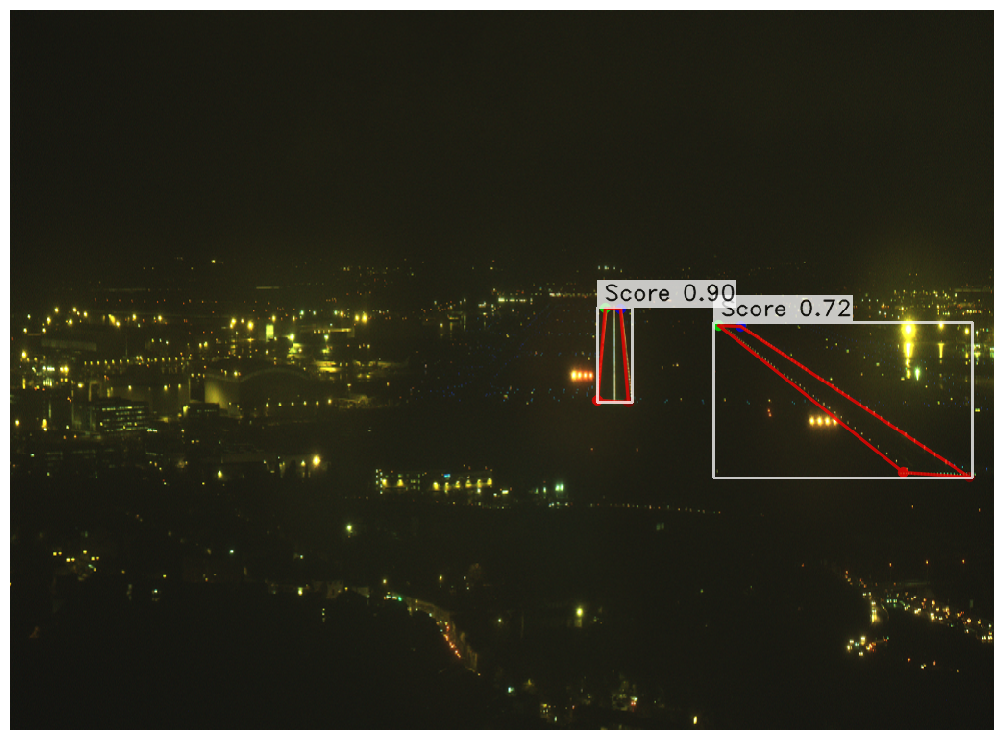

: 

In [24]:
predict("./tmp/unnamed.png", conf=0.6)

In [ ]:
predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT136/20230623_235312/extracted_images/cam-nav/20230624_014601/cam-nav_20230624_014634_633949096_063415.jpeg")

In [ ]:
predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT128/20230417_141823/extracted_images/cam-nav/20230417_154055/cam-nav_20230417_154135_017482504_047551.jpeg")

In [ ]:
predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT126/20230414_213913/extracted_images/cam-nav/20230414_224343/cam-nav_20230414_224625_764864280_038113.jpeg")

In [ ]:
predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT112/20230222_233246/extracted_images/cam-nav/20230223_013125/cam-nav_20230223_013302_519238496_070570.jpeg")

In [ ]:
predict("/mnt/data1/extracted_data/flight_test/owl_r2/FT64/20220405_164230/extracted_images/cam-nav/20220405_172312/cam-nav_20220405_172312_753243928_022835.jpeg")

In [ ]:
predict("/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q3/coco-k4-1024x750-0.01/valid/images/0000000613.jpeg")

In [ ]:
model.predict("/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q3/coco-k4-1024x750-0.01/valid/images/0000001512.jpeg", conf=0.20).show()

In [ ]:
model.predict("/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q3/coco-k4-1024x750-0.01/valid/images/0000005095.jpeg", conf=0.20).show()

In [ ]:
model.predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT150/20230713_002635/extracted_images/cam-nav/20230713_010935/cam-nav_20230713_011006_974051080_023893.jpeg", conf=0.20).show()

In [ ]:
model.predict("/mnt/data1/extracted_data/flight_test/owl_p1/FT161/20230820_233446/extracted_images/cam-nav/20230821_005515/cam-nav_20230821_005530_121882936_046052.jpeg", conf=0.20).show()

----

In [20]:
model.export?

Signature:
model.export(
    output: str,
    confidence_threshold: Optional[float] = None,
    nms_threshold: Optional[float] = None,
    engine: Optional[super_gradients.conversion.conversion_enums.ExportTargetBackend] = None,
    quantization_mode: Optional[super_gradients.conversion.conversion_enums.ExportQuantizationMode] = None,
    selective_quantizer: Optional[ForwardRef('SelectiveQuantizer')] = None,
    calibration_loader: Optional[torch.utils.data.dataloader.DataLoader] = None,
    calibration_method: str = 'percentile',
    calibration_batches: int = 16,
    calibration_percentile: float = 99.99,
    preprocessing: Union[bool, torch.nn.modules.module.Module] = True,
    postprocessing: Union[bool, torch.nn.modules.module.Module] = True,
    postprocessing_kwargs: Optional[dict] = None,
    batch_size: int = 1,
    input_image_shape: Optional[Tuple[int, int]] = None,
    input_image_channels: Optional[int] = None,
    input_image_dtype: Optional[torch.dtype] = None,
    max_

In [9]:
from super_gradients.conversion import DetectionOutputFormatMode

export_result = model.export(
    ckpt_dirpath + "/" + "export_fp32_raw.onnx",
    confidence_threshold=0.3,
    nms_threshold=0.2,
    onnx_simplify=False,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    postprocessing=False
)
display(export_result)


Model exported successfully to /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/export_fp32_raw.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/export_fp32_raw.onnx", providers=["CUDAExecutio

In [8]:
from super_gradients.conversion import DetectionOutputFormatMode

export_result = model.export(
    ckpt_dirpath + "/" + "export_fp32.onnx",
    confidence_threshold=0.3,
    nms_threshold=0.2,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    postprocessing=False
)
display(export_result)

export_result = model.export(
    ckpt_dirpath + "/" + "export_nms_fp32.onnx",
    confidence_threshold=0.3,
    nms_threshold=0.2,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    postprocessing=True
)
display(export_result)

2024-01-30 06:14:41.530730837 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23444959737600, mask: 62, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:41.530774927 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23444957636352, mask: 63, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:41.534577428 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23441012856576, mask: 123, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:41.534684918 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23441010755328, mask: 124, error code: 22 error msg: Invalid argument. Specify the number of threads expli


Model exported successfully to /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/export_fp32.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/export_fp32.onnx", providers=["CUD

2024-01-30 06:14:45.448200834 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23441048577792, mask: 125, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:45.448268914 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23441044375296, mask: 127, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:45.448267424 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23441046476544, mask: 126, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-01-30 06:14:47.863039800 [E:onnxruntime:Default, env.cc:231 ThreadMain] pthread_setaffinity_np failed for thread: 23445100259072, mask: 63, error code: 22 error msg: Invalid argument. Specify the number of threads expl


Model exported successfully to /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_12_baseline/RUN_20240115_130238_322613/export_nms_fp32.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)


Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.2
    confidence_threshold=0.3
    output_predictions_format=flat


Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onn

In [12]:
# from super_gradients.conversion import ExportQuantizationMode

# export_result = model.export(
#     ckpt_dirpath + "/" + "export_fp16.onnx",
#     confidence_threshold=0.5,
#     nms_threshold=0.3,
#     output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
#     quantization_mode=ExportQuantizationMode.FP16,
#     postprocessing=False
# )
# display(export_result)

# export_result = model.export(
#     ckpt_dirpath + "/" + "export_nms_fp16.onnx",
#     confidence_threshold=0.5,
#     nms_threshold=0.3,
#     output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
#     quantization_mode=ExportQuantizationMode.FP16,
#     postprocessing=True
# )
# display(export_result)

RuntimeError: "slow_conv2d_cpu" not implemented for 'Half'

In [8]:
import functools
import torchvision
from typing import Iterable
from super_gradients.training.transforms.keypoints import KeypointsLongestMaxSize, KeypointsPadIfNeeded, KeypointsImageStandardize
import time
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.predict.predictions import PoseEstimationPrediction
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

def _rescale_image(image, target_shape):
    """Rescale image to target_shape, without preserving aspect ratio.

    :param image:           Image to rescale. (H, W, C) or (H, W).
    :param target_shape:    Target shape to rescale to (H, W).
    :return:                Rescaled image.
    """
    height, width = target_shape[:2]
    return cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

def apply_to_image(img, scale, interpolation):
    height, width = img.shape[:2]

    if scale != 1.0:
        new_height, new_width = tuple(int(dim * scale + 0.5) for dim in (height, width))
        img = cv2.resize(img, (new_width, new_height), interpolation=interpolation)
    return img

def longest_max_size(image, max_height=1024, max_width=1024):
    height, width = image.shape[:2]
    scale = min(max_height / height, max_width / width)
    return apply_to_image(image, scale, cv2.INTER_LINEAR)

def pad_if_needed(image, min_height=1024, min_width=1024, image_pad_value=127, padding_mode="bottom_right"):
    height, width = image.shape[:2]

    if padding_mode == "bottom_right":
        pad_left = 0
        pad_top = 0
        pad_bottom = max(0, min_height - height)
        pad_right = max(0, min_width - width)
    elif padding_mode == "center":
        pad_left = max(0, (min_width - width) // 2)
        pad_top = max(0, (min_height - height) // 2)
        pad_bottom = max(0, min_height - height - pad_top)
        pad_right = max(0, min_width - width - pad_left)
    else:
        raise RuntimeError(f"Unknown padding mode: {padding_mode}")

    image_pad_value = tuple(image_pad_value) if isinstance(image_pad_value, Iterable) else tuple([image_pad_value] * image.shape[-1])
    image = cv2.copyMakeBorder(
        image, top=pad_top, bottom=pad_bottom, left=pad_left, right=pad_right, value=image_pad_value, borderType=cv2.BORDER_CONSTANT
    )

    return image

def standardize(image, max_value=255):
    return np.divide(image, max_value, dtype=np.float32)

def preprocess(image):
    image = longest_max_size(
        image,
        max_height=1024,
        max_width=1024
    )
    image = pad_if_needed(
        image,
        min_height=1024,
        min_width=1024,
        image_pad_value=127,
        padding_mode="bottom_right"
    )
    return image

In [110]:
import torch
from torch.utils.data import DataLoader, Dataset
from super_gradients.conversion import DetectionOutputFormatMode
from super_gradients.conversion import ExportQuantizationMode
from super_gradients.training.datasets import COCOPoseEstimationDataset
from super_gradients.training.transforms.keypoints import KeypointsLongestMaxSize, KeypointsPadIfNeeded, KeypointsImageStandardize
from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN

# dummy_calibration_dataset = [torch.randn((3, 640, 640), dtype=torch.float32) for _ in range(32)]
# dataset = "valid"
dataset = "train"

calibration_dataset = COCOPoseEstimationDataset(
    # data_dir="/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q4/coco-k4-1024x750",
    data_dir="/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q3/coco-k4-1024x750-0.01",
    images_dir=dataset + "/images",
    json_file=dataset + "/annotations.json",
    edge_links=[
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0]
    ],
    edge_colors=[
        [255, 0, 0],
        [255, 0, 0],
        [255, 0, 0],
        [255, 0, 0]
    ],
    keypoint_colors=[
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [128, 0, 0]
    ],
    include_empty_samples=False,
    transforms=[
        KeypointsLongestMaxSize(
            max_height=1024,
            max_width=1024
        ),
        KeypointsPadIfNeeded(
            min_height=1024,
            min_width=1024,
            image_pad_value=127,
            mask_pad_value=1,
            padding_mode="bottom_right"
        ),
        KeypointsImageStandardize(
            max_value=255
        )
    ]
)

def collate(x):
    return YoloNASPoseCollateFN()(x)[0]

class CalibrationDataset(Dataset):

    def __init__(self, images_dirpath: str, size = (1024, 1024)):
        self.images_dirpath = images_dirpath
        self.images_filepaths = [images_dirpath + "/" + f for f in os.listdir(images_dirpath)]

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, index):
        image_filepath = self.images_filepaths[index]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess(image) / 255.
        return torch.tensor(image.astype(np.float32).transpose(2, 1, 0))

calibration_dataset = CalibrationDataset(
    images_dirpath="/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_Q3/coco-k4-1024x750-0.01/train/images"
)

calibration_dataloader = DataLoader(
    dataset=calibration_dataset,
    batch_size=48,
    num_workers=8,
    # collate_fn=collate
)

loading annotations into memory...


torch.Size([1, 1024, 1024, 3])

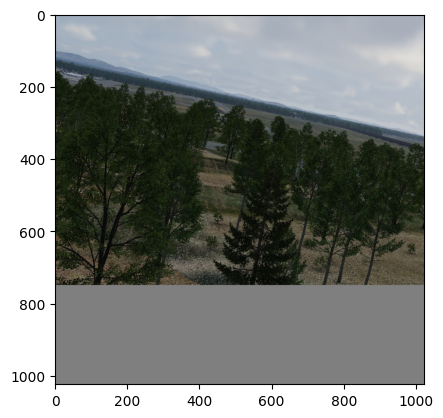

In [105]:
plt.imshow(calibration_dataset[0])

next(iter(calibration_dataloader)).shape

In [111]:
export_result = model.export(
    ckpt_dirpath + "/" + "export_int8.onnx",
    device=1,
    confidence_threshold=0.5,
    nms_threshold=0.3,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    quantization_mode=ExportQuantizationMode.INT8,
    calibration_loader=calibration_dataloader,
    calibration_batches=len(calibration_dataloader),
    postprocessing=False
)
display(export_result)

Done (t=0.29s)
creating index...
index created!


100%|██████████| 281/281 [56:17<00:00, 12.02s/it]
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 12:56:16.854427 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 12:56:16.855847 23456244156224 tensor_quantizer.py:174] Disable MaxCalibrator
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 12:56:16.856854 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 12:56:16.857763 23456244156224 tensor_quantizer.py:174] Disable MaxCalibrator
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 12:56:16.858699 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 12:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 12:56:16.859589 23456244156224 t

backbone.stem.conv.rbr_reparam._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=0.9995 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stem.conv.rbr_reparam._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[1.0523, 11.8078](32) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.downsample.rbr_reparam._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=12.2172 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stage1.downsample.rbr_reparam._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[0.3596, 2.5764](64) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv1.conv._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=11.6169 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv1.conv._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[0.6787, 1.2589](32) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv2.conv._input_quantizer: TensorQuantizer(8bit fake per-te

[2023-11-24 12:56:17] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([68, 1, 1, 1]).
W1124 12:56:17.201638 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([68, 1, 1, 1]).
[2023-11-24 12:56:17] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([]).
W1124 12:56:17.203812 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
[2023-11-24 12:56:17] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([5, 1, 1, 1]).
W1124 12:56:17.204406 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([5, 1, 1, 1]).
[2023-11-24 12:56:17] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([]).
W1124 12:56:17.205947 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
[2023-11-24 12:56:17] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([8, 1, 1, 1]).
W1124 12:56:17.206552 234562441562

heads.head3.reg_pred._weight_quantizer  : TensorQuantizer(8bit fake axis=0 amax=[0.8089, 7.4304](68) calibrator=MaxCalibrator scale=1.0 quant)
heads.head3.cls_pred._input_quantizer   : TensorQuantizer(8bit fake per-tensor amax=4.0658 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head3.cls_pred._weight_quantizer  : TensorQuantizer(8bit fake axis=0 amax=[1.3037, 5.7157](5) calibrator=MaxCalibrator scale=1.0 quant)
heads.head3.pose_pred._input_quantizer  : TensorQuantizer(8bit fake per-tensor amax=2.9111 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head3.pose_pred._weight_quantizer : TensorQuantizer(8bit fake axis=0 amax=[0.6756, 0.9539](8) calibrator=MaxCalibrator scale=1.0 quant)


/home/geoffrey.g.delhomme/projects/super-gradients/.venv/lib/python3.10/site-packages/pytorch_quantization-2.1.3-py3.10-linux-x86_64.egg/pytorch_quantization/nn/modules/tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/home/geoffrey.g.delhomme/projects/super-gradients/.venv/lib/python3.10/site-packages/pytorch_quantization-2.1.3-py3.10-linux-x86_64.egg/pytorch_quantization/nn/modules/tensor_quantizer.py:286: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  inputs, amax.item() / bound, 0,
/home/geoffrey.g.delhomme


Model exported successfully to /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_Q4_baseline/RUN_20231121_125446_838578/export_int8.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:1'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("/home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_Q4_baseline/RUN_20231121_125446_838578/export_int8.onnx", providers=["CUD

In [112]:
export_result = model.export(
    ckpt_dirpath + "/" + "export_nms_int8.onnx",
    device=1,
    confidence_threshold=0.5,
    nms_threshold=0.3,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    quantization_mode=ExportQuantizationMode.INT8,
    calibration_loader=calibration_dataloader,
    calibration_batches=len(calibration_dataloader),
    postprocessing=True
)
display(export_result)

100%|██████████| 281/281 [57:07<00:00, 12.20s/it]
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 13:56:16.405164 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 13:56:16.406930 23456244156224 tensor_quantizer.py:174] Disable MaxCalibrator
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 13:56:16.408131 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 13:56:16.409189 23456244156224 tensor_quantizer.py:174] Disable MaxCalibrator
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable HistogramCalibrator
W1124 13:56:16.410001 23456244156224 tensor_quantizer.py:174] Disable HistogramCalibrator
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Disable MaxCalibrator
W1124 13:56:16.410614 23456244156224 t

backbone.stem.conv.rbr_reparam._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=0.9995 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stem.conv.rbr_reparam._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[1.0523, 11.8078](32) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.downsample.rbr_reparam._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=12.2172 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stage1.downsample.rbr_reparam._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[0.3596, 2.5764](64) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv1.conv._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=11.6169 calibrator=HistogramCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv1.conv._weight_quantizer: TensorQuantizer(8bit fake axis=0 amax=[0.6787, 1.2589](32) calibrator=MaxCalibrator scale=1.0 quant)
backbone.stage1.blocks.conv2.conv._input_quantizer: TensorQuantizer(8bit fake per-te

W1124 13:56:16.766273 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([68, 1, 1, 1]).
W1124 13:56:16.767246 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([68, 1, 1, 1]).
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([]).
W1124 13:56:16.768822 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([5, 1, 1, 1]).
W1124 13:56:16.769509 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([5, 1, 1, 1]).
[2023-11-24 13:56:16] WARNING - tensor_quantizer.py - Load calibrated amax, shape=torch.Size([]).
W1124 13:56:16.770900 23456244156224 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([]).
[2023-11-24 13:56:16] WARNING - tens

heads.head1.reg_pred._input_quantizer   : TensorQuantizer(8bit fake per-tensor amax=5.0845 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head1.reg_pred._weight_quantizer  : TensorQuantizer(8bit fake axis=0 amax=[0.4374, 1.9757](68) calibrator=MaxCalibrator scale=1.0 quant)
heads.head1.cls_pred._input_quantizer   : TensorQuantizer(8bit fake per-tensor amax=9.8495 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head1.cls_pred._weight_quantizer  : TensorQuantizer(8bit fake axis=0 amax=[1.0130, 2.0636](5) calibrator=MaxCalibrator scale=1.0 quant)
heads.head1.pose_pred._input_quantizer  : TensorQuantizer(8bit fake per-tensor amax=6.0337 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head1.pose_pred._weight_quantizer : TensorQuantizer(8bit fake axis=0 amax=[0.6576, 1.1975](8) calibrator=MaxCalibrator scale=1.0 quant)
heads.head2.pose_stem.seq.conv._input_quantizer: TensorQuantizer(8bit fake per-tensor amax=5.8292 calibrator=HistogramCalibrator scale=1.0 quant)
heads.head

2023-11-24 13:56:24.000112282 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 1061351, index: 18, mask: {19, 59, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-11-24 13:56:24.000768808 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 1061370, index: 37, mask: {38, 78, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-11-24 13:56:24.000798580 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 1061371, index: 38, mask: {39, 79, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
/home/geoffrey.g.delhomme/projects/super-gradients/.venv/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:5856: UserWarning: Exporting aten::index operator of advanced indexing in 


Model exported successfully to /home/geoffrey.g.delhomme/projects/super-gradients/checkpoints/aip_yolo_nas_pose_n_1024_2023_Q4_baseline/RUN_20231121_125446_838578/export_nms_int8.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:1'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)


Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.3
    confidence_threshold=0.5
    output_predictions_format=flat


Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onn

----

In [7]:
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

def iterate_over_flat_predictions(predictions, batch_size):
    [flat_predictions] = predictions

    for image_index in range(batch_size):
        mask = flat_predictions[:, 0] == image_index
        pred_bboxes = flat_predictions[mask, 1:5]
        pred_scores = flat_predictions[mask, 5]
        pred_joints = flat_predictions[mask, 6:].reshape((len(pred_bboxes), -1, 3))
        yield image_index, pred_bboxes, pred_scores, pred_joints

def show_predictions_from_flat_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_joints = next(iter(iterate_over_flat_predictions(predictions, 1)))

    image = PoseVisualization.draw_poses(
        image=image, poses=pred_joints, scores=pred_scores, boxes=pred_boxes,
        is_crowd=None,
        edge_links=[
            [0, 1],
            [1, 2],
            [2, 3],
            [3, 0]
        ],
        edge_colors=[
            [255, 0, 0],
            [255, 0, 0],
            [255, 0, 0],
            [255, 0, 0]
        ],
        keypoint_colors=[
            [255, 0, 0],
            [0, 255, 0],
            [0, 0, 255],
            [128, 0, 0]
        ]
    )

    return image

In [8]:
import functools
import torchvision
from typing import Iterable
from super_gradients.training.transforms.keypoints import KeypointsLongestMaxSize, KeypointsPadIfNeeded, KeypointsImageStandardize
import time
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.predict.predictions import PoseEstimationPrediction
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

def _rescale_image(image, target_shape):
    """Rescale image to target_shape, without preserving aspect ratio.

    :param image:           Image to rescale. (H, W, C) or (H, W).
    :param target_shape:    Target shape to rescale to (H, W).
    :return:                Rescaled image.
    """
    height, width = target_shape[:2]
    return cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

def apply_to_image(img, scale, interpolation):
    height, width = img.shape[:2]

    if scale != 1.0:
        new_height, new_width = tuple(int(dim * scale + 0.5) for dim in (height, width))
        img = cv2.resize(img, (new_width, new_height), interpolation=interpolation)
    return img

def longest_max_size(image, max_height=1024, max_width=1024):
    height, width = image.shape[:2]
    scale = min(max_height / height, max_width / width)
    return apply_to_image(image, scale, cv2.INTER_LINEAR)

def pad_if_needed(image, min_height=1024, min_width=1024, image_pad_value=127, padding_mode="bottom_right"):
    height, width = image.shape[:2]

    if padding_mode == "bottom_right":
        pad_left = 0
        pad_top = 0
        pad_bottom = max(0, min_height - height)
        pad_right = max(0, min_width - width)
    elif padding_mode == "center":
        pad_left = max(0, (min_width - width) // 2)
        pad_top = max(0, (min_height - height) // 2)
        pad_bottom = max(0, min_height - height - pad_top)
        pad_right = max(0, min_width - width - pad_left)
    else:
        raise RuntimeError(f"Unknown padding mode: {padding_mode}")

    image_pad_value = tuple(image_pad_value) if isinstance(image_pad_value, Iterable) else tuple([image_pad_value] * image.shape[-1])
    image = cv2.copyMakeBorder(
        image, top=pad_top, bottom=pad_bottom, left=pad_left, right=pad_right, value=image_pad_value, borderType=cv2.BORDER_CONSTANT
    )

    return image

def standardize(image, max_value=255):
    return np.divide(image, max_value, dtype=np.float32)

def preprocess(image):
    image = longest_max_size(
        image,
        max_height=1024,
        max_width=1024
    )
    image = pad_if_needed(
        image,
        min_height=1024,
        min_width=1024,
        image_pad_value=127,
        padding_mode="bottom_right"
    )
    return image

def postprocess(
    im,
    predictions,
    conf = 0.5,
    iou = 0.3,
    pre_nms_max_predictions = 1000,
    post_nms_max_predictions = 300):

    bboxes, bboxes_conf, keypoints, keypoints_conf = [torch.tensor(p) for p in predictions]

    bboxes_conf = bboxes_conf.squeeze(-1)
    conf_mask = bboxes_conf >= conf

    bboxes = bboxes[conf_mask]
    bboxes_conf = bboxes_conf[conf_mask]
    keypoints = keypoints[conf_mask]
    keypoints_conf = keypoints_conf[conf_mask]

    if len(bboxes_conf) > pre_nms_max_predictions:
        topk_candidates = torch.topk(bboxes_conf, k=pre_nms_max_predictions, largest=True, sorted=True)
        bboxes = bboxes[topk_candidates.indices]
        bboxes_conf = bboxes_conf[topk_candidates.indices]
        keypoints = keypoints[topk_candidates.indices]
        keypoints_conf = keypoints_conf[topk_candidates.indices]

    idx_to_keep = torchvision.ops.boxes.nms(boxes=bboxes, scores=bboxes_conf, iou_threshold=iou).numpy()

    final_bboxes = bboxes[idx_to_keep]  # [Instances,]
    final_scores = bboxes_conf[idx_to_keep]  # [Instances,]

    final_poses = torch.cat(
        [
            keypoints[idx_to_keep],
            keypoints_conf[idx_to_keep].unsqueeze(-1),
        ],
        dim=-1,
    )  # [Instances, Num Keypoints, 3]

    # p = PoseEstimationPrediction(
    #     poses=final_poses[: post_nms_max_predictions].numpy(),
    #     scores=final_scores[: post_nms_max_predictions].numpy(),
    #     bboxes_xyxy=final_bboxes[: post_nms_max_predictions].numpy(),
    #     image_shape=im.shape,
    #     edge_links=np.array(edge_links),
    #     edge_colors=np.array(edge_colors),
    #     keypoint_colors=np.array(keypoint_colors)
    # )

    # imr = PoseVisualization.draw_poses(
    #     image=im,
    #     poses=p.poses,
    #     scores=p.scores,
    #     is_crowd=None,
    #     boxes=p.bboxes_xyxy,
    #     edge_links=edge_links,
    #     edge_colors=edge_colors,
    #     joint_thickness=2,
    #     keypoint_colors=keypoint_colors,
    #     keypoint_radius=5,
    #     box_thickness=2,
    # )

    # return imr

    return final_bboxes, final_scores, final_poses


def add_text(im, text, pos_w, pos_h, font = cv2.FONT_HERSHEY_DUPLEX, font_scale = 1.0, font_thickness = 2):

    size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]

    return cv2.putText(
        im,
        text = text,
        org = (int(pos_w-size[0]/2), int(pos_h+size[1]/2)),
        fontFace = font,
        fontScale = font_scale,
        color = (125, 246, 55),
        thickness = font_thickness
    )


def predict_sequence_compare(models, data, flight_test, recording_seq_id, conf=0.50, iou=0.3, imax=None, gpu_id=0, suffix=None):
    samples = [x for x in data if x['flight_test'] == flight_test and x['recording_seq_id'] == recording_seq_id]
    indexes = np.argsort([x['timestamp'].timestamp() for x in samples])
    video_output_filepath = ckpt_dirpath + "/videos/" + flight_test + "_" + str(recording_seq_id) + (("_" + suffix) if suffix is not None else "") + ".avi"
    Path(video_output_filepath).parent.mkdir(exist_ok=True)
    video = cv2.VideoWriter(video_output_filepath,cv2.VideoWriter_fourcc('M','J','P','G'), 10.0, (1024*len(models), 750))
    sessions = {}
    for model_name, model in models.items():
        if isinstance(model, str):
            # sessions[model_name] = onnxruntime.InferenceSession(model, providers=["TensorrtExecutionProvider", "CUDAExecutionProvider", "CPUExecutionProvider"])
            print("Starting onnx runtime inference sessions for "+model)
            providers = [
                ('CUDAExecutionProvider', {
                    'device_id': gpu_id,
                }),
                'CPUExecutionProvider',
            ]
            sessions[model_name] = onnxruntime.InferenceSession(model, providers=providers)
        else:
            sessions[model_name] = None
    callback = YoloNASPosePostPredictionCallback(
        pose_confidence_threshold=conf,
        nms_iou_threshold=iou,
        pre_nms_max_predictions=1000,
        post_nms_max_predictions=300
    )
    for i, index in tqdm(enumerate(indexes)):
        s = samples[index]
        atd = s['labels']['runways'][0]['aircraft_rel_position']['along_track_offset_m']
        if atd < -6000 or atd > -300:
            continue
        im = cv2.imread(s['image_path'])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        results = {}
        for model_name, session in sessions.items():
            imc = im.copy()
            model = models[model_name]
            imc = preprocess(imc)
            if not isinstance(model, str):
                tic = time.perf_counter()
                res = model.predict(imc, conf=conf, iou=iou)._images_prediction_lst[0].draw()
                elapsed = time.perf_counter() - tic
                res = res[:750,:1024]
            else:
                inputs = [o.name for o in session.get_inputs()]
                outputs = [o.name for o in session.get_outputs()]
                image_bchw = np.transpose(np.expand_dims(imc, 0), (0, 3, 1, 2))
                tic = time.perf_counter()
                result = session.run(outputs, {inputs[0]: image_bchw})
                elapsed = time.perf_counter() - tic
                if "nms" in model_name:
                    poses, scores, bboxes = result[0][:, 6:].reshape(-1, 4, 3), result[0][:, 5], result[0][:, 1:5]
                    res = PoseVisualization.draw_poses(
                        image=imc,
                        poses=poses,
                        scores=scores,
                        is_crowd=None,
                        boxes=bboxes,
                        edge_links=edge_links,
                        edge_colors=edge_colors,
                        joint_thickness=2,
                        keypoint_colors=keypoint_colors,
                        keypoint_radius=5,
                        box_thickness=2,
                    )
                else:
                    res = postprocess(imc, result)
                res = res[:750,:1024]
                res = add_text(res, model_name, int(1024/2), 30)
                res = add_text(res, f"inference: {elapsed*1.e3:.3f} ms ({torch.cuda.get_device_name(0)})", int(1024/2), 750-30)
            results[model_name] = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
        res = np.concatenate(list(results.values()), axis=1)
        if i == 0:
            plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
            plt.show()
        video.write(res)
        if imax is not None and i > imax:
            break
    video.release()

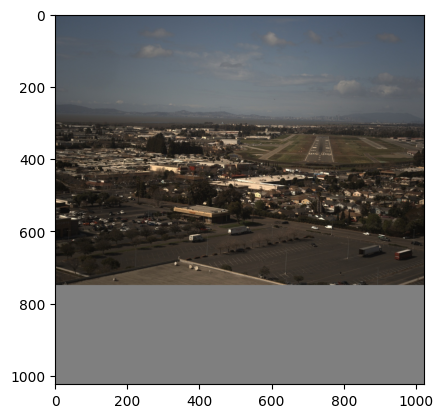

In [16]:
import cv2
import numpy as np
import onnxruntime

image_filepath = "/home/juan.rivero-sesma/projects/aip-inference/test/vls/data/test_image.jpeg"

imr = cv2.imread(image_filepath)
im = cv2.cvtColor(imr, cv2.COLOR_BGR2RGB)
im = preprocess(im)

plt.figure()
plt.imshow(im)

model = ckpt_dirpath + "/" + "export_fp32.onnx"
session = onnxruntime.InferenceSession(model)

inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
image_bchw = np.transpose(np.expand_dims(im, 0), (0, 3, 1, 2))
result = session.run(outputs, {inputs[0]: image_bchw})

final_bboxes, final_scores, final_poses = postprocess(im, result)

In [33]:
final_bboxes

tensor([[702.1665, 337.6961, 767.8073, 391.1852],
        [835.3958, 340.8998, 923.0627, 377.3613]])

In [34]:
final_scores

tensor([0.8098, 0.6923])

In [35]:
final_poses

tensor([[[7.0386e+02, 3.8905e+02, 9.4671e-01],
         [7.2550e+02, 3.3950e+02, 9.1809e-01],
         [7.5510e+02, 3.3982e+02, 9.3524e-01],
         [7.6533e+02, 3.8921e+02, 9.6626e-01]],

        [[8.9583e+02, 3.7436e+02, 9.8550e-01],
         [8.3428e+02, 3.4155e+02, 9.8230e-01],
         [8.5230e+02, 3.4225e+02, 9.8195e-01],
         [9.2247e+02, 3.7618e+02, 9.8474e-01]]])

(1000, 1365, 3)
tensor([702.1665, 337.6961, 767.8073, 391.1852])
tensor([835.3958, 340.8998, 923.0627, 377.3613])


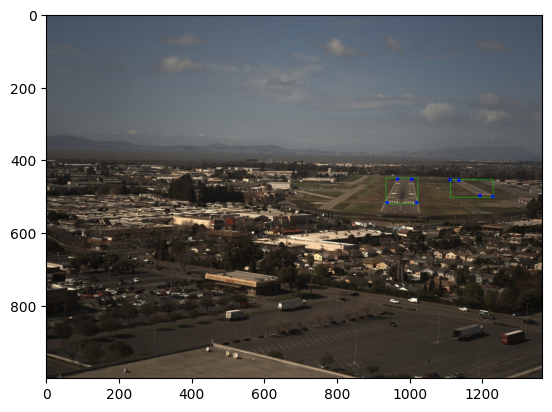

In [17]:
imc = imr.copy()
print(imr.shape)

for poses in final_poses:
    for kpt in poses:
        x, y, c = kpt
        x = int(x * imc.shape[1] / 1024)
        y = int(y * imc.shape[0] / 750)
        cv2.circle(imc, center=(x,y), radius=5, color=(255, 0, 0), thickness=-1)

for bbox in final_bboxes:
    print(bbox)
    pt0 = (int(bbox[0] * imc.shape[1] / 1024), int(bbox[1] * imc.shape[0] / 750))
    pt1 = (int(bbox[2] * imc.shape[1] / 1024), int(bbox[3] * imc.shape[0] / 750))
    cv2.rectangle(imc, pt0, pt1, (0, 255, 0))

plt.figure()
plt.imshow(cv2.cvtColor(imc, cv2.COLOR_BGR2RGB))

In [ ]:

res = im.copy()
res = res[:750,:1024]

plt.figure()
plt.imshow(res)

In [121]:
# TODO: continue here after exporting quantized onnx (+qat)
models = {
    "fp32": ckpt_dirpath + "/" + "export_fp32.onnx",
    # "fp16": ckpt_dirpath + "/" + "export_fp16.onnx",
    "int8": ckpt_dirpath + "/" + "export_int8.onnx",
}
suffix = "fp32_int8"

In [130]:
# TODO: continue here after exporting quantized onnx (+qat)
models = {
    "fp32": ckpt_dirpath + "/" + "export_fp32.onnx",
    # "fp16": ckpt_dirpath + "/" + "export_fp16.onnx",
    # "int8": ckpt_dirpath + "/" + "export_int8.onnx",
}
suffix = "fp32"

In [11]:
# TODO: continue here after exporting quantized onnx (+qat)
models = {
    "torch": model,
    # "fp16": ckpt_dirpath + "/" + "export_fp16.onnx",
    # "int8": ckpt_dirpath + "/" + "export_int8.onnx",
}
suffix = None

In [119]:
# TODO: continue here after exporting quantized onnx (+qat)
models = {
    "fp32 (nms)": ckpt_dirpath + "/" + "export_nms_fp32.onnx",
    # "fp16": ckpt_dirpath + "/" + "export_fp16.onnx",
    "int8 (nms)": ckpt_dirpath + "/" + "export_nms_int8.onnx",
}
suffix = "nms_fp32_int8"

In [ ]:
# TODO: continue here after exporting quantized onnx (+qat)
models = {
    "fp32 (nms)": ckpt_dirpath + "/" + "export_nms_fp32.onnx",
    # "fp16": ckpt_dirpath + "/" + "export_fp16.onnx",
    # "int8 (nms)": ckpt_dirpath + "/" + "export_nms_int8.onnx",
}
suffix = "nms_fp32"

0it [00:00, ?it/s]

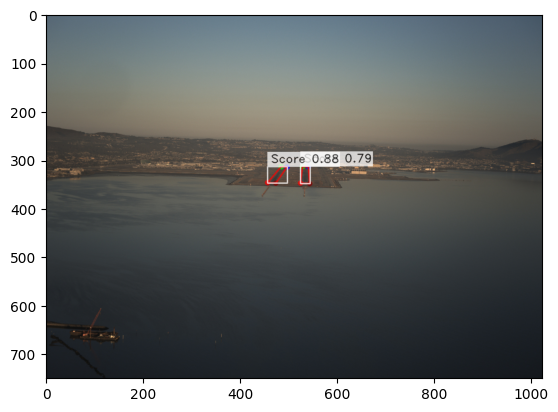

824it [06:46,  1.96it/s]

In [12]:
predict_sequence_compare(models, data, 'FT101', 6, suffix=suffix)

825it [06:47,  2.03it/s]
0it [00:00, ?it/s]

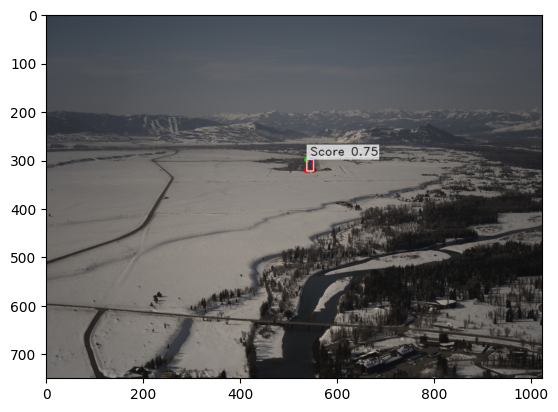

89it [00:45,  1.95it/s]

655it [05:30,  2.09it/s]

In [13]:
predict_sequence_compare(models, data, 'FT128', 6, suffix=suffix)

656it [05:31,  1.98it/s]
0it [00:00, ?it/s]

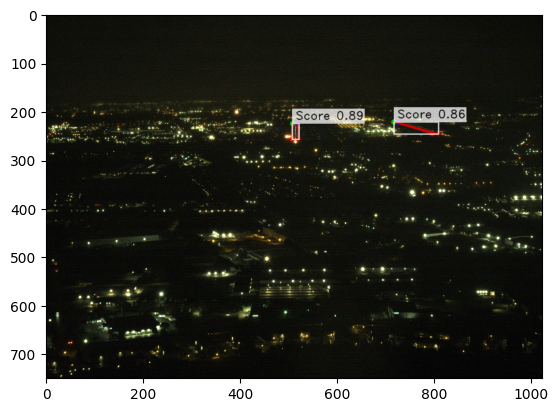

75it [00:38,  1.95it/s]

743it [06:36,  1.82it/s]

In [14]:
predict_sequence_compare(models, data, 'FT156', 4, suffix=suffix)

744it [06:37,  1.87it/s]
0it [00:00, ?it/s]

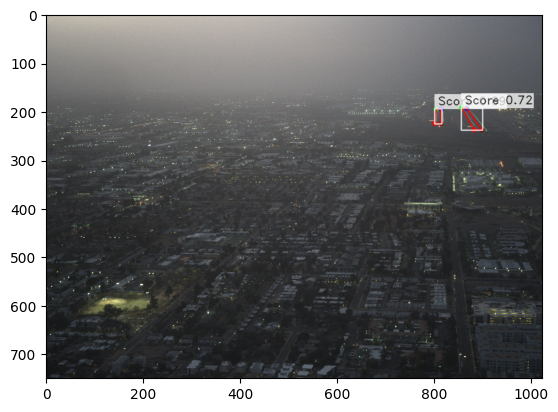

83it [00:46,  1.84it/s]

812it [07:16,  1.83it/s]

In [15]:
predict_sequence_compare(models, data, 'FT112', 12, suffix=suffix)

813it [07:17,  1.86it/s]
0it [00:00, ?it/s]

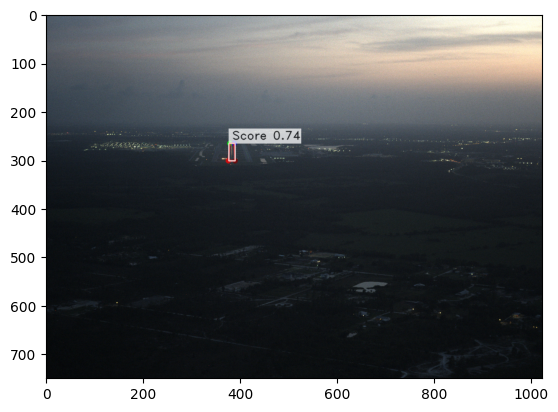

36it [00:18,  1.89it/s]

785it [08:27,  1.79it/s]

In [16]:
predict_sequence_compare(models, data, 'FT148', 7, suffix=suffix)

786it [08:27,  1.55it/s]
0it [00:00, ?it/s]

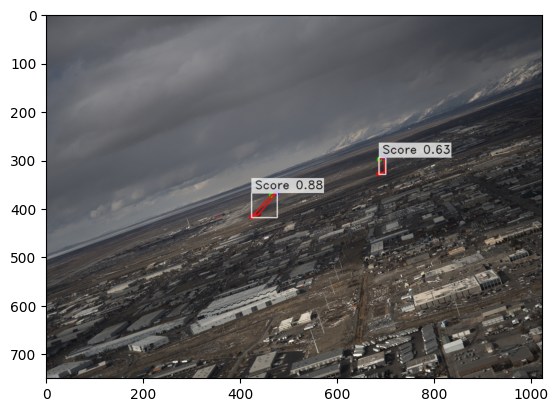

92it [00:49,  1.91it/s]

750it [06:28,  2.00it/s]

In [17]:
predict_sequence_compare(models, data, 'FT116', 19, suffix=suffix)

751it [06:29,  1.93it/s]


0it [00:00, ?it/s]

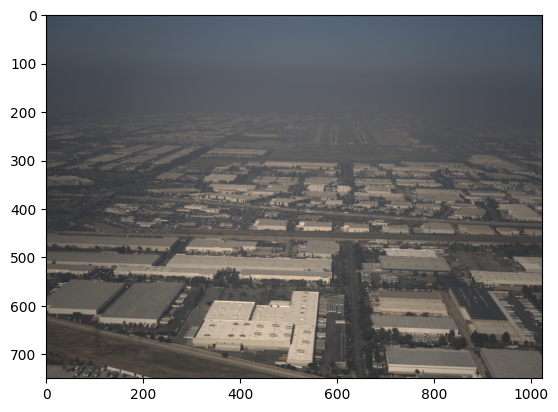

665it [05:30,  2.09it/s]

In [18]:
predict_sequence_compare(models, data, 'FT64', 4, suffix=suffix)

666it [05:30,  2.02it/s]
0it [00:00, ?it/s]

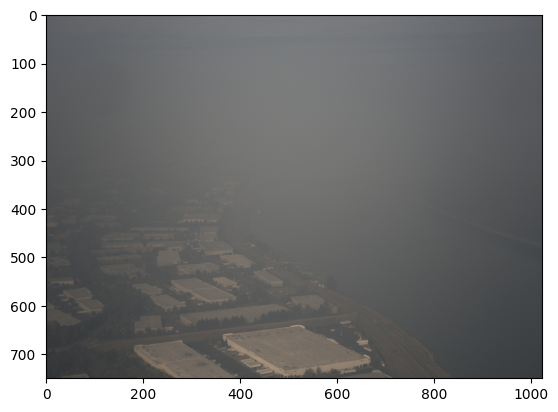

37it [00:17,  2.17it/s]

661it [05:15,  2.02it/s]

In [19]:
predict_sequence_compare(models, data, 'FT105', 5, suffix=suffix)

662it [05:15,  2.10it/s]
0it [00:00, ?it/s]

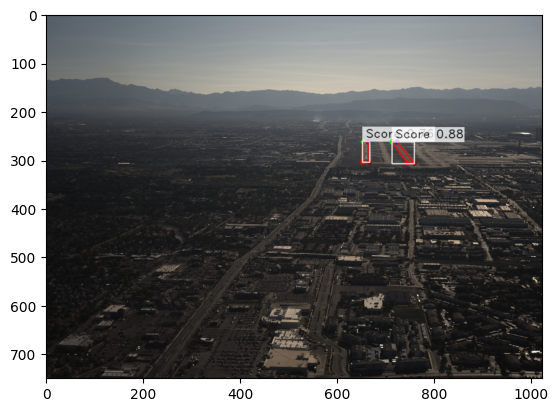

51it [00:25,  1.90it/s]

797it [06:26,  1.97it/s]

In [20]:
predict_sequence_compare(models, data, 'FT135', 4, suffix=suffix)

798it [06:26,  2.06it/s]
0it [00:00, ?it/s]

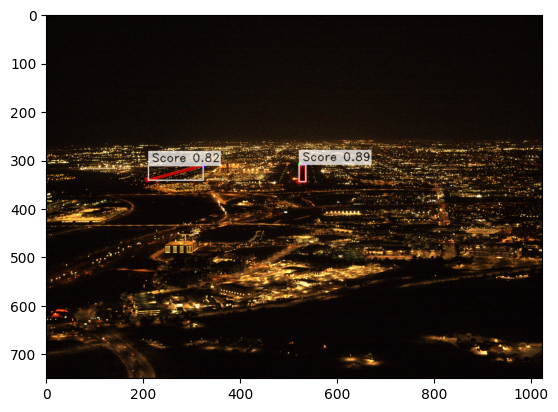

23it [00:12,  1.88it/s]

1110it [10:00,  1.78it/s]

1111it [10:01,  1.85it/s]


In [21]:
predict_sequence_compare(models, data, 'FT135', 10, suffix=suffix)